In [858]:
"""customize the figure"""
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick.major', size=8)
matplotlib.rc('xtick.minor', size=4)
matplotlib.rc('ytick.major', size=8)
matplotlib.rc('ytick.minor', size=4)

In [859]:
import os
from lxml import etree
import pandas as pd
#from glob import glob
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
##to create table
from astropy.table import Table, Column

In [860]:
def parse_vr(filename):
    """Returns the Primary unit/divisor, Secondary unit/divisor, sampling rate and recording duration. 
    Returned as a dictionary with keys "primary", "secondary", "sampling", and "duration". 
    Primary and Secondary values are contained in dictionaries with keys "unit" and "divisor"
    """

    tree = etree.parse(filename)
    #Returns elements with associated "Primary" and "Secondary
    primary = tree.xpath('.//Name[text()="Primary"]')
    secondary = tree.xpath('.//Name[text()="Secondary"]')
    #Gets the parent of these elements
    try:
        parent = (primary[0].getparent(), secondary[0].getparent())
    #in case people don't use capital letters for Primary and Secondary labels in PrairieView
    except IndexError:
        primary = tree.xpath('.//Name[text()="primary"]')
        secondary = tree.xpath('.//Name[text()="secondary"]')
        parent = (primary[0].getparent(), secondary[0].getparent())
    #Finds the unit element within parent
    unit = (parent[0].find('.//UnitName'), parent[1].find('.//UnitName'))
    #Finds the divisor element within parent
    divisor = (parent[0].find('.//Divisor'), parent[1].find('.//Divisor'))

    #dictionaries with primary and secondary values
    primary_val = {'unit': unit[0].text, 'divisor': float(divisor[0].text)}
    secondary_val = {'unit': unit[1].text, 'divisor': float(divisor[1].text)}
    #gets sampling rate
    sampling_val = int((tree.find('.//Rate')).text)
    #gets recording time, converts to sec
    duration_val = (int((tree.find('.//AcquisitionTime')).text))/1000

    #finds the voltage recording csv file name
    datafile = (tree.find('.//DataFile')).text
    #finds the linescan profile file name (if doesn't exist, will be None)
    ls_file = (tree.find('.//AssociatedLinescanProfileFile')).text

    #If ls_file is none this could mean that there is no linescan associate with that voltage recording file or that
    #the file passed to parse_vr is actually a LineScan data file and therefore should be passed to ls_file.
    #In that scenario there is no voltage recording data file, so vo_file is None
    if ls_file is None:
        if "LineScan" in datafile:
            ls_file = datafile
            vo_file = None
        elif "LineScan" not in datafile:
            vo_file = datafile
    else:
        vo_file = datafile

    return {'primary': primary_val, 'secondary': secondary_val, 'sampling': sampling_val, 'duration': duration_val,
            'linescan file': ls_file, 'voltage recording file': vo_file}


In [861]:
def import_bot_csv(filename):
    """Reads BOTdata.csv file into pandas dataframe. """
    #loads csv file into pandas dataframe
    df = pd.read_csv(filename, skipinitialspace=True)
    return df

In [862]:
L_BOTdata1 = import_bot_csv('/Users/shenyuzhai/Desktop/in_progress/01132021/BOT-20210113_slice1_20Hz-001_Cycle00001-botData.csv')
L_BOTdata2 = import_bot_csv('/Users/shenyuzhai/Desktop/in_progress/01132021/BOT-20210113_slice1_20Hz-002_Cycle00001-botData.csv')
H_BOTdata1 = import_bot_csv('/Users/shenyuzhai/Desktop/in_progress/01132021/BOT-20210113_slice1_DA20Hz-001_Cycle00001-botData.csv')
H_BOTdata2 = import_bot_csv('/Users/shenyuzhai/Desktop/in_progress/01132021/BOT-20210113_slice1_DA20Hz-001_Cycle00001-botData.csv')
#print(L_BOTdata2['Region 1'])
#print(L_BOTdata2['Region 1'])

In [863]:
#Subtract PMT background
#bg_PMT1 = 55
bg_PMT2 = 174
L_BOTdata1['Region 1'] = L_BOTdata1['Region 1'].apply(lambda x: (x-bg_PMT2))
L_BOTdata2['Region 1'] = L_BOTdata2['Region 1'].apply(lambda x: (x-bg_PMT2))
H_BOTdata1['Region 1'] = H_BOTdata1['Region 1'].apply(lambda x: (x-bg_PMT2))
H_BOTdata2['Region 1'] = H_BOTdata2['Region 1'].apply(lambda x: (x-bg_PMT2))
#Average two replicate traces
L_BOT_data = pd.concat([L_BOTdata1, L_BOTdata2['Region 1']], axis=1)
H_BOT_data = pd.concat([H_BOTdata1, H_BOTdata2['Region 1']], axis=1)
L_BOT_data.columns = ['Time', 'Trial1', 'Trial2']
H_BOT_data.columns = ['Time', 'Trial1', 'Trial2']
L_BOT_data['Average'] = L_BOT_data[['Trial1', 'Trial2']].mean(axis=1)
H_BOT_data['Average'] = H_BOT_data[['Trial1', 'Trial2']].mean(axis=1)

(20, 95)

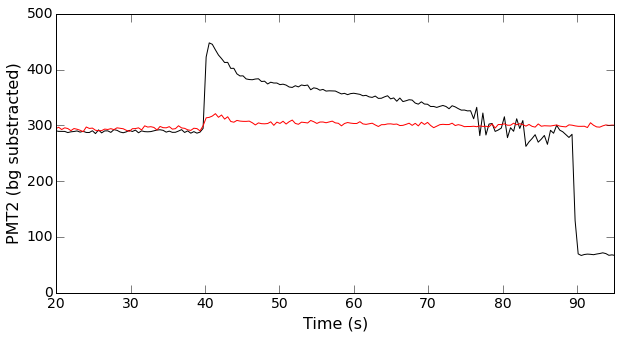

In [864]:
#Plot the average trace
plt.figure(figsize=(10,5))
plt.plot(L_BOT_data.Time, L_BOT_data.Average, color = 'black')
plt.plot(H_BOT_data.Time, H_BOT_data.Average, color = 'red')
plt.ylabel('PMT2 (bg substracted)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.ylim(0,500)
plt.xlim(20,95)

In [865]:
##Sampling interval
TimeInterval = L_BOT_data['Time'][20] - L_BOT_data['Time'][19]
#print(TimeInterval1)
##index of 20 s, 30s, 70s
IndexTimeA = int(20/TimeInterval)
IndexTimeB = int(30/TimeInterval)
IndexTimeC = int(80/TimeInterval)
#print(IndexTimeA, IndexTimeB, IndexTimeC)
print ([L_BOT_data['Time'][IndexTimeB], H_BOT_data['Time'][IndexTimeB]])

[29.823896899999998, 29.826896899999998]


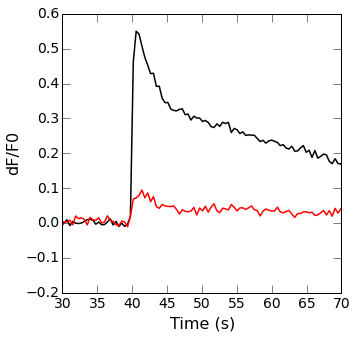

In [867]:
"""calculations for control condition"""
L_F0 = L_BOT_data['Average'][IndexTimeA:IndexTimeB].mean() ##Calculate F0 value by average from TimeA to TimeB
H_F0 = H_BOT_data['Average'][IndexTimeA:IndexTimeB].mean()
L_deltaFoverF0 = (L_BOT_data['Average']-L_F0)/L_F0    ##Calculate dF/F0
H_deltaFoverF0 = (H_BOT_data['Average']-H_F0)/H_F0
L_AUC = (L_deltaFoverF0[(IndexTimeB+1):IndexTimeC].sum())*TimeInterval
H_AUC = (H_deltaFoverF0[(IndexTimeB+1):IndexTimeC].sum())*TimeInterval
plt.figure(figsize=(5,5))
plt.plot(L_BOT_data['Time'], L_deltaFoverF0, color='black', linewidth=1.5)
plt.plot(H_BOT_data['Time'], H_deltaFoverF0, color='red', linewidth=1.5)
plt.ylabel('dF/F0', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.xlim(30,70)
plt.ylim(-0.2,0.6)
plt.savefig('dG_over_R0.pdf')

(0, 90)

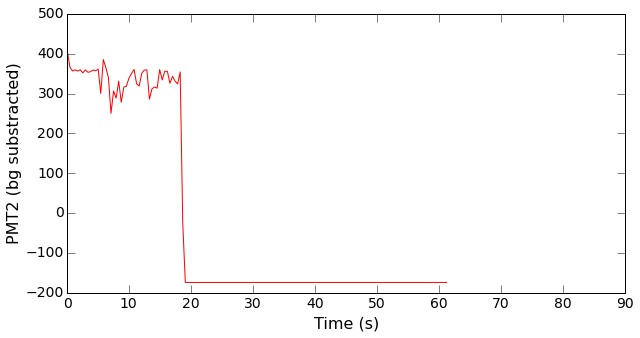

In [794]:
Fmax_BOTdata = import_bot_csv('/Users/shenyuzhai/Desktop/in_progress/01122021/BOT-20210112_slice2_Ach-001_Cycle00001-botData.csv')
#Subtract PMT background
#bg_PMT1 = 55
bg_PMT2 = 174
Fmax_BOTdata['Region 1'] = Fmax_BOTdata['Region 1'].apply(lambda x: (x-bg_PMT2))
Fmax_BOTdata.columns = ['Time', 'Fmax']
#Plot the average trace
plt.figure(figsize=(10,5))
plt.plot(Fmax_BOTdata.Time, Fmax_BOTdata.Fmax, color = 'red')

plt.ylabel('PMT2 (bg substracted)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.xlim(0,90)

In [795]:
print(L_F0)

262.354678329


In [796]:
##Sampling interval
TimeInterval = Fmax_BOTdata['Time'][5] - Fmax_BOTdata['Time'][4]
#print(TimeInterval1)
##index of desired window for Fmax calculation
IndexTimeE = int(5/TimeInterval)
IndexTimeF = int(15/TimeInterval)
"""calculations for control condition"""
Fmax_final = Fmax_BOTdata['Fmax'][IndexTimeE:IndexTimeF].mean()
Fmax_final

326.17400901666667

In [797]:
L_deltaFoverFI = (L_BOT_data['Average']-L_F0)/(Fmax_final-L_F0)    ##Calculate dF/FI
H_deltaFoverFI = (H_BOT_data['Average']-H_F0)/(Fmax_final-H_F0)
L_AUC2 = (L_deltaFoverFI[(IndexTimeB+1):IndexTimeC].sum())*TimeInterval
H_AUC2 = (H_deltaFoverFI[(IndexTimeB+1):IndexTimeC].sum())*TimeInterval

#result_values = [L_deltaFoverF0[(IndexTimeB+1):IndexTimeC].max(), L_AUC]
#result_names = ['Amplitude', 'AUC']
#pd.DataFrame(result_values, index = result_names)
L_results_values = [L_deltaFoverFI[(IndexTimeB+1):IndexTimeC].max(), L_AUC2]
H_results_values = [H_deltaFoverFI[(IndexTimeB+1):IndexTimeC].max(), H_AUC2]
result_names = ['Amplitude', 'AUC']

d = {'20uA stim':L_results_values,'50uA stim':H_results_values}
pd.DataFrame(d, index = result_names)

,20uA stim,50uA stim
Amplitude,1.41466,0.381721
AUC,25.08868,7.901286
